In [22]:
from __future__ import division, print_function, absolute_import
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import scatter, figure, subplot, savefig
import time
from functools import partial
import scedar
from sklearn.cluster import AgglomerativeClustering
import utils
import os

In [2]:
try: data
except: data  =  pd.read_csv('/Users/dawnstear/desktop/Mid_Atlantic_Poster/sc_data/n_1078/data.csv')  
print(np.shape(data))

np.random.seed(42)
data = shuffle(data)
celltypes = data['TYPE'] # save cell type vector in case we need it later
y = data['Labels'] # save labels
X = data.drop(['Labels','TYPE'],axis=1) 
cellcount, genecount = np.shape(X)

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.2,random_state=144)
# Create Data Object for batch retrieval
batchObj = utils.Data(X,y)

(1078, 26596)


In [3]:
n_inputs = genecount
n_hidden1 = 300
n_hidden2 = 2 # latent space dimension
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 1e-2
l2_reg = 1e-3

X = tf.placeholder(tf.float32,shape=[None, n_inputs])

#activation = tf.nn.elu
he_initializer = tf.contrib.layers.variance_scaling_initializer() #he_init
regularizer = tf.contrib.layers.l2_regularizer(l2_reg) # l2_regularizer



In [4]:
# Tie Encoder weights to Decoder weights, save space
weights1_init =  he_initializer([n_inputs, n_hidden1])
weights2_init = he_initializer([n_hidden1, n_hidden2])

weights1 = tf.Variable(weights1_init, dtype=tf.float32,name='weights1')
weights2 = tf.Variable(weights2_init, dtype=tf.float32,name='weights2_encoded')
weights3 = tf.transpose(weights2,name='weights3') # tied
weights4 = tf.transpose(weights1,name='weights4') # tied

biases1 = tf.Variable(tf.zeros(n_hidden1),name='biases1')
biases2 = tf.Variable(tf.zeros(n_hidden2),name='biases2')
biases3 = tf.Variable(tf.zeros(n_hidden3),name='biases3')
biases4 = tf.Variable(tf.zeros(n_outputs),name='biases4')

hidden1 = tf.nn.elu(tf.matmul(X,weights1) + biases1)
hidden2 = tf.nn.elu(tf.matmul(hidden1,weights2) + biases2)
hidden3 = tf.nn.elu(tf.matmul(hidden2,weights3) + biases3)
outputs = tf.matmul(hidden3,weights4) + biases4

print(tf.trainable_variables())

[<tf.Variable 'weights1:0' shape=(26594, 300) dtype=float32_ref>, <tf.Variable 'weights2_encoded:0' shape=(300, 2) dtype=float32_ref>, <tf.Variable 'biases1:0' shape=(300,) dtype=float32_ref>, <tf.Variable 'biases2:0' shape=(2,) dtype=float32_ref>, <tf.Variable 'biases3:0' shape=(300,) dtype=float32_ref>, <tf.Variable 'biases4:0' shape=(26594,) dtype=float32_ref>]


In [5]:
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
reg_loss = regularizer(weights1) + regularizer(weights2)
loss = reconstruction_loss + reg_loss
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

n_epochs = 80
batch_size = 85
n_batches = cellcount//batch_size
TrainLossVec = []

Epoch 0- Average Loss: 17.0440731048584
Epoch 1- Average Loss: 15.586136420567831
Epoch 2- Average Loss: 14.656606038411459
Epoch 3- Average Loss: 12.121734062830607
Epoch 4- Average Loss: 10.083479324976603
Epoch 5- Average Loss: 7.945001602172852
Epoch 6- Average Loss: 6.3295295635859175
Epoch 7- Average Loss: 5.583338220914205
Epoch 8- Average Loss: 5.409634510676066
Epoch 9- Average Loss: 5.3346736033757525
Epoch 10- Average Loss: 5.329075455665588
Epoch 11- Average Loss: 5.286602894465129
Epoch 12- Average Loss: 5.267145713170369
Epoch 13- Average Loss: 5.242042660713196
Epoch 14- Average Loss: 5.30928647518158
Epoch 15- Average Loss: 5.270862857500712
Epoch 16- Average Loss: 5.205891489982605
Epoch 17- Average Loss: 5.263561765352885
Epoch 18- Average Loss: 5.368919491767883
Epoch 19- Average Loss: 5.164523879686992
Epoch 20- Average Loss: 5.237512985865275
Epoch 21- Average Loss: 5.258097370465596
Epoch 22- Average Loss: 5.138484477996826
Epoch 23- Average Loss: 5.28224333127339

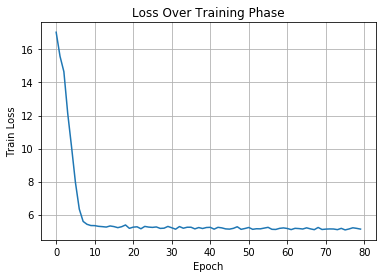

In [6]:
# Early Stopping
min_delta = 0.01
patience = 6


init = tf.global_variables_initializer()
start = time.time()

# Train Model
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
        avg_loss = 0
        
        for iteration in range(n_batches):
            X_train_batch, y_batch = batchObj.train_batch(batch_size=batch_size)
            _, iter_loss = sess.run([training_op, loss], feed_dict={X: X_train_batch})
            avg_loss += iter_loss
            
        avg_loss = avg_loss/n_batches    
        TrainLossVec = np.append(TrainLossVec,avg_loss)     
        print('Epoch %s- Average Loss: %s' % (epoch,avg_loss))
        
    latent_space0 = sess.run('weights2_encoded:0')
    #latent_space1 = sess.run('weights2_encoded_1:0')
    #latent_space2 = sess.run('weights2_encoded_2:0')
    
    
print('Training %s epochs took %s seconds' % (n_epochs, time.time()-start))    
# *--------------- Plot Training Loss Results -------------------*   
fig, ax = plt.subplots()
ax.plot(range(n_epochs),TrainLossVec)
#ax.plot(range(n_epochs),TrainLossVec)
ax.set(xlabel='Epoch', ylabel='Train Loss',title='Loss Over Training Phase') # include time//epoch//batch size in title
ax.grid()


Epoch 0- Average Loss: 0.07223307587379633
Epoch 1- Average Loss: 1.7622439267791368
Epoch 2- Average Loss: 0.05241967883339088
Epoch 3- Average Loss: 0.01736391540861086
Epoch 4- Average Loss: 0.17450351885845938
Epoch 5- Average Loss: 0.0449723053057938
Epoch 6- Average Loss: 0.14970087840948915
Epoch 7- Average Loss: 0.1610517490665485
Epoch 8- Average Loss: 0.2156524081510908
Epoch 9- Average Loss: 0.02994529564227365
Epoch 10- Average Loss: 0.030104641219398112
Epoch 11- Average Loss: 0.2208278523124485
Epoch 12- Average Loss: 0.06507514592577192
Epoch 13- Average Loss: 0.05835488446352875
Epoch 14- Average Loss: 0.2268950419374121
Epoch 15- Average Loss: 0.03778739616702131
Epoch 16- Average Loss: 0.0562731674403844
Epoch 17- Average Loss: 0.19788924236218638
Epoch 18- Average Loss: 0.110913937192514
Epoch 19- Average Loss: 0.037693545730083274
Epoch 20- Average Loss: 0.06430660756757633
Epoch 21- Average Loss: 0.09625672790765442
Epoch 22- Average Loss: 0.13688304144714045
Epoch

ValueError: x and y must have same first dimension, but have shapes (80,) and (215,)

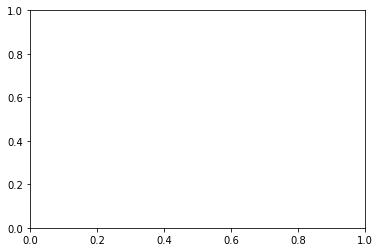

In [9]:
# Test model and record each instances' 2D - latent space
latent_data = []
TestLossVec = []
test_size = 0.2
batch_size_test = 1 # just go through cells 1 by 1 and record 2D lat-space each time
n_epochs_test = int(np.floor(cellcount*test_size))
avg_loss_test = 0

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs_test):

            X_test_batch, y_batch = batchObj.test_batch(batch_size=batch_size_test)
            _, iter_loss = sess.run([training_op, loss], feed_dict={X: X_test_batch})
            
            latent_space = sess.run('weights2_encoded:0')
            #latent_space2 = sess.run('weights2_encoded_2:0')
            latent_data = np.append(latent_data,latent_space)
            #latent_data2 = np.append(latent_data2,latent_space2)
            
            avg_loss_test += iter_loss
            avg_loss_test = avg_loss_test/n_epochs_test
            
            TestLossVec = np.append(TestLossVec,avg_loss_test)     
            print('Epoch %s- Average Loss: %s' % (epoch,avg_loss_test))
        
    
# *--------------- Plot Test Loss Results -------------------*   
fig, ax = plt.subplots()
ax.plot(range(n_epochs_test),TestLossVec)
ax.set(xlabel='Epoch', ylabel='Test Loss',title='Loss Over Testing Phase') # include time//epoch//batch size in title
ax.grid()


In [14]:
print(np.shape(latent_data))
print(tf.trainable_variables())
c = 129000/215
print(c)


(129000,)
[<tf.Variable 'weights1:0' shape=(26594, 300) dtype=float32_ref>, <tf.Variable 'weights2_encoded:0' shape=(300, 2) dtype=float32_ref>, <tf.Variable 'biases1:0' shape=(300,) dtype=float32_ref>, <tf.Variable 'biases2:0' shape=(2,) dtype=float32_ref>, <tf.Variable 'biases3:0' shape=(300,) dtype=float32_ref>, <tf.Variable 'biases4:0' shape=(26594,) dtype=float32_ref>]
600.0


In [32]:
FPATH = '/Users/dawnstear/desktop/chop_cellpred/newimg.pdf'
#path = os.path.join(n_epochs+arch+time_elapsed)
#fig.savefig(FPATH)
print(np.shape(latent_space1))

(300, 2)


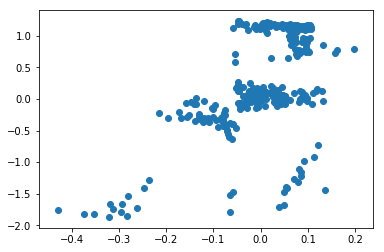

<Figure size 7200x7200 with 0 Axes>

In [21]:
fig, ax = plt.subplots()
figure(figsize=(100, 100))
#subplot(121)
#ax.set(xlabel='t-SNE 1', ylabel='t_SNE 2',title='t-SNE: 1078 cells with 10 subtypes')
#ax.legend(y)
ax.scatter(latent_space[:, 0], latent_space[:, 1]) #,c=y_batch[0:301])

In [26]:
# compare different latspace sizes


######### CLUSTERING ###########
AggClust = AgglomerativeClustering(n_clusters=4,linkage='ward')
t = time.time()
AggClust.fit(X_train)
#number_of_clusters = len(np.unique(labels))
e = time.time()
print(e-t)



11.152708768844604


In [29]:
print(AggClust)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=4,
            pooling_func=<function mean at 0x10b858a60>)
